In [2]:
import os
import os.path as op
from mne import io
import mne
import numpy as np
import torch
from functools import partial
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

In [3]:
raw_path = r'/vol/megdata/raw'

night = 'Night2'
s = 'S10'

In [4]:

data_path_folder = op.join(raw_path, rf'{s}/{night}')
wm = os.listdir(data_path_folder)[-1]
print(wm)
data_path = op.join(raw_path, rf'{s}/{night}/{wm}')

10_Sleep_20171206_04.ds


In [5]:
raw = io.read_raw_ctf(data_path, preload=True)
raw.pick_types(meg=True, stim=True, ref_meg=True)

ds directory : /vol/megdata/raw/S10/Night2/10_Sleep_20171206_04.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
      -1.80   70.05    0.00 mm <->   -1.80   70.05    0.00 mm (orig :  -48.43   52.45 -261.10 mm) diff =    0.000 mm
       1.80  -70.05    0.00 mm <->    1.80  -70.05    0.00 mm (orig :   53.62  -43.61 -260.40 mm) diff =    0.000 mm
      89.49    0.00    0.00 mm <->   89.49   -0.00    0.00 mm (orig :   64.05   66.50 -241.26 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    10 EEG electrode locations assigned to channel info.
    10 EEG locations added to Polhemus data.
    Measurement info composed.
Finding samples for /vol/megdata/raw/S10/Night2/10_Sleep_20171206_04.ds/10_Sleep_20171206_04.meg4: 
    System clock channel is available, checking which samples are valid.
    2 x

<RawCTF | 10_Sleep_20171206_04.meg4, 297 x 2469447 (2107.3 s), ~5.46 GiB, data loaded>

In [6]:
## print amount of channels
print(f'Number of channels: {len(raw.ch_names)}')

Number of channels: 297


In [7]:
events = mne.find_events(raw, stim_channel='UDIO001', initial_event=True)
event_ids = {"maint_FACE": 43, "maint_HOUSE": 53}

events[:,2] = events[:,2] - 255
sel = np.where(events[:, 2] <= 255)[0]
events = events[sel, :]
picks = mne.pick_types(raw.info, meg='mag', eeg=True, stim=False,
                        exclude='bads')
epochs = mne.Epochs(raw, events, event_ids,  picks=picks,tmin=-.2, tmax=4,\
                    baseline=None, preload=True)

## x and y channel location


2266 events found on stim channel UDIO001
Event IDs: [  257   258   259   260   261   264   265   266   268   287   288   289
   290   291   292   293   294   295   296   297   298   299   300   301
   302   303   306   307   308   309   310   311   312   313   511  1280
  2304  2344  2352  2353  2354  2362  2363  4352  4392  4400  4401  4402
  4410  4411 16640 17156]


Not setting metadata
400 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 400 events and 4923 original time points ...
0 bad epochs dropped


(295, 2)
295


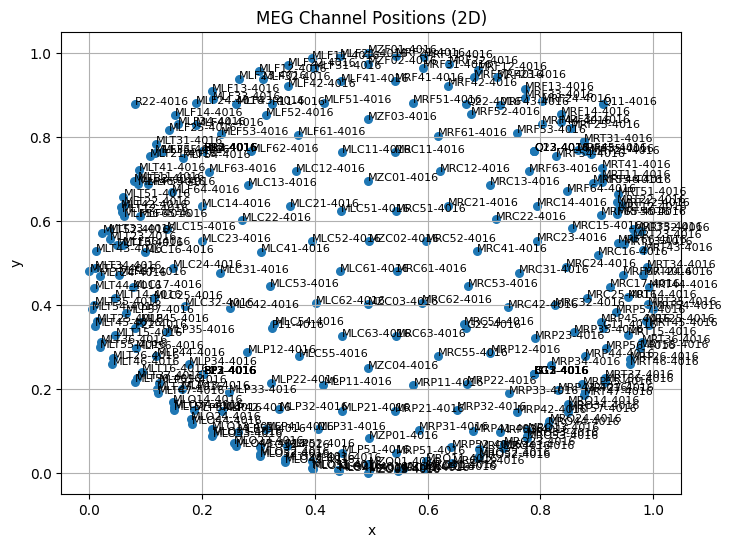

In [8]:

meg_picks = mne.pick_types(raw.info, meg=True)

loc = np.array([raw.info['chs'][i]['loc'][:2] for i in meg_picks])
loc = (loc - loc.min(axis=0)) / (loc.max(axis=0) - loc.min(axis=0))
pos_2d = loc
print(pos_2d.shape)
np.save("/home/ubuntu/BrainDecoding/configs/montage.npy", pos_2d)
ch_names = [raw.info['ch_names'][i] for i in meg_picks]
print(len(pos_2d))
# Optional: plot to visualize
plt.figure(figsize=(8, 6))
plt.scatter(pos_2d[:, 0], pos_2d[:, 1], s=30)
for i, name in enumerate(ch_names):
    plt.text(pos_2d[i, 0], pos_2d[i, 1], name, fontsize=8)
plt.title("MEG Channel Positions (2D)")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

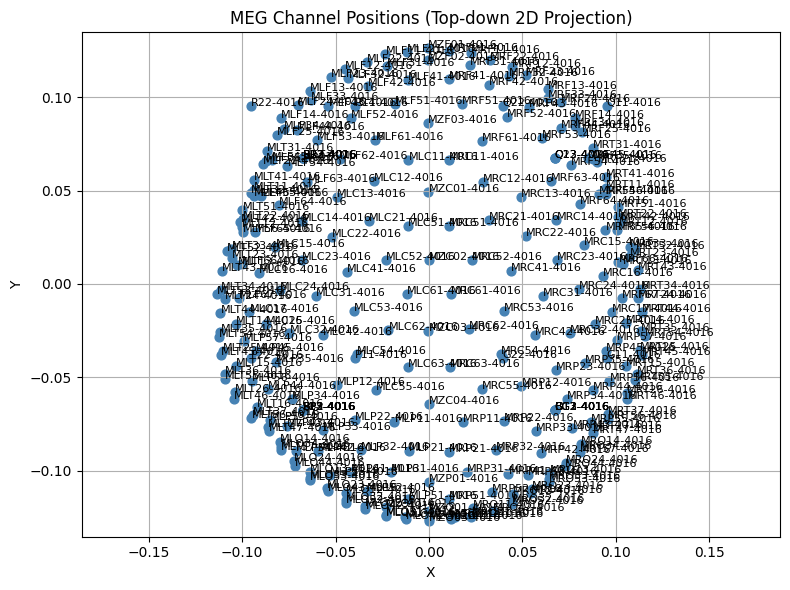

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Get MEG channel indices and 3D positions
meg_picks = mne.pick_types(raw.info, meg=True)
pos_3d = np.array([raw.info['chs'][i]['loc'][:3] for i in meg_picks])
ch_names = [raw.info['ch_names'][i] for i in meg_picks]

# Simple projection: just take X and Y (ignore Z)
pos_2d = pos_3d[:, :2]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(pos_2d[:, 0], pos_2d[:, 1], s=40, color='steelblue')
for i, name in enumerate(ch_names):
    plt.text(pos_2d[i, 0], pos_2d[i, 1], name, fontsize=8)

plt.title("MEG Channel Positions (Top-down 2D Projection)")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.axis('equal')
plt.tight_layout()
plt.show()


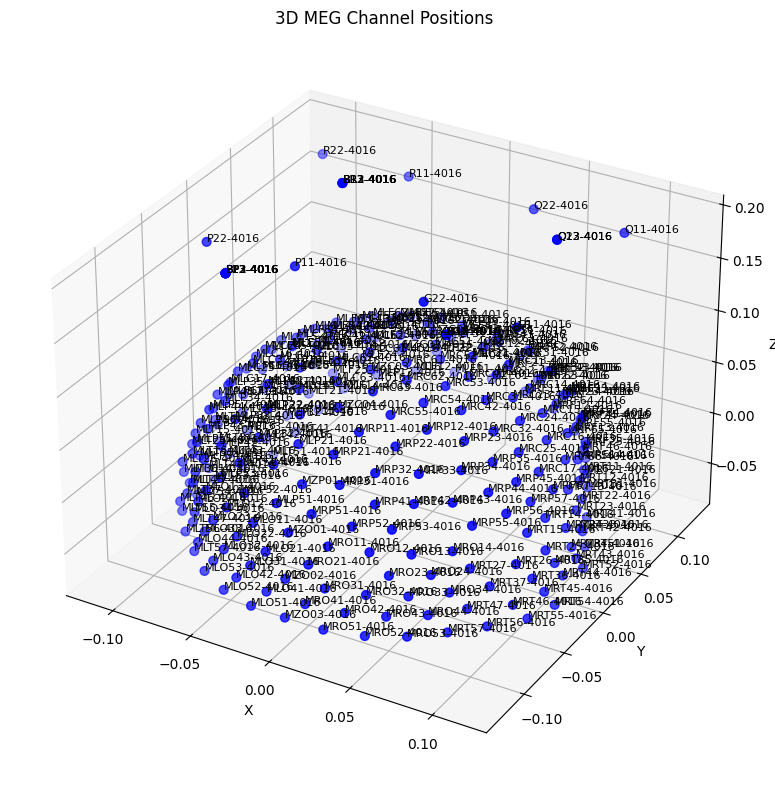

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

# Get MEG channel indices
meg_picks = mne.pick_types(raw.info, meg=True)

# Extract 3D positions: loc[:3] = x, y, z in device/head space
pos_3d = np.array([raw.info['chs'][i]['loc'][:3] for i in meg_picks])
ch_names = [raw.info['ch_names'][i] for i in meg_picks]

# 3D Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_3d[:, 0], pos_3d[:, 1], pos_3d[:, 2], s=40, c='b')

# Annotate with channel names (optional)
for i, name in enumerate(ch_names):
    ax.text(pos_3d[i, 0], pos_3d[i, 1], pos_3d[i, 2], name, fontsize=8)

ax.set_title("3D MEG Channel Positions")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.tight_layout()
plt.show()


In [ ]:
epochs.resample(120)
def scale_clamp(
    X: np.ndarray,
    clamp_lim: float = 5.0,
    clamp: bool = True,
) -> np.ndarray:
    X = X.reshape(X.shape[0], -1)
    X = RobustScaler().fit_transform(X)
    if clamp:
        X = X.clip(min=-clamp_lim, max=clamp_lim)
    return X.squeeze()

epochs.apply_function(partial(scale_clamp, clamp_lim=5.0), n_jobs=8)
meg_data = torch.from_numpy(epochs.get_data(picks='meg')).to(torch.float32)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done  96 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 279 out of 279 | elapsed:    6.1s finished


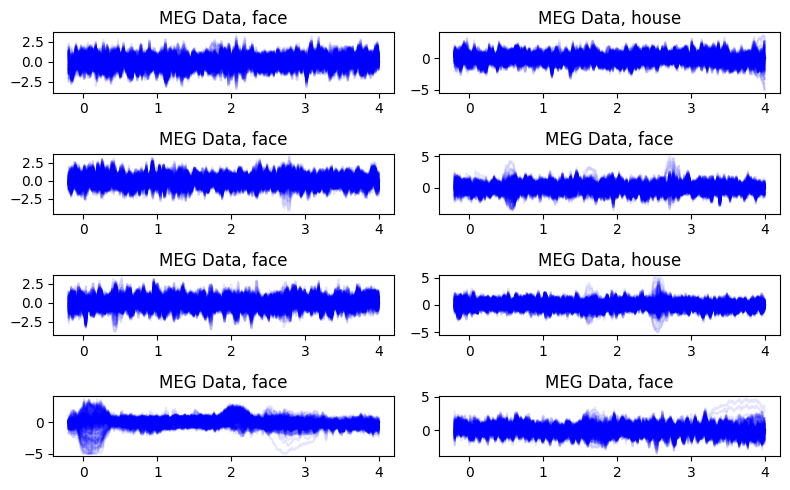

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=(8, 5))
for idx, ax in enumerate(ax.flatten()):
    np.random.seed(idx)
    rnd_int = np.random.randint(0, meg_data.shape[0])
    for i in range(meg_data.shape[1]):
        ax.plot(epochs.times, meg_data[rnd_int, i, :].numpy(), color='blue', alpha=0.1)
    ax.set_title(f'MEG Data, {'house' if epochs.events[rnd_int, 2] == 43 else 'face'}')
plt.tight_layout()
plt.show()